# **ANYLOSS CODE FOR MULTI-LAYER PERCEPTRON(MLP)**

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv('/content/drive/MyDrive/Datasets/breast_cancer.csv')
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [2]:
Y = data['diagnosis']
Y = data['diagnosis'].replace({'M': 1, 'B': 0})
X_features = ['radius_mean','texture_mean','perimeter_mean','area_mean','smoothness_mean','compactness_mean','concavity_mean','concave points_mean','symmetry_mean','fractal_dimension_mean']
X = data[X_features]

<ipython-input-2-1e8c66989196>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Y = data['diagnosis'].replace({'M': 1, 'B': 0})


In [3]:
X_train_a, X_test_a, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation
from tensorflow.keras import optimizers

#MSE
def MSE(y_true, y_pred):
    return tf.reduce_mean(tf.math.square(y_true - y_pred))

#BCE
def BCE(y_true, y_pred):
    return -tf.reduce_mean(y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))

#AnyLoss-Accuracy
def Ours_Accu(y_true, y_pred):
    y_pred = 1 / (1 + tf.math.exp(-L * (y_pred - 0.5)))
    yl = y_train.shape[0]
    accu = (yl - tf.reduce_sum(y_true) - tf.reduce_sum(y_pred) + 2 * tf.reduce_sum(y_true * y_pred)) / yl
    return 1 - accu

#AnyLoss-Fbeta
def Ours_Fbeta(y_true, y_pred):
    beta = 1
    y_pred = 1 / (1 + tf.math.exp(-L * (y_pred - 0.5)))
    numerator = (1 + beta**2) * tf.reduce_sum(y_true * y_pred)
    denominator = (beta**2) * tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return 1 - (numerator / denominator)

#AnyLoss-Gmean
def Ours_Gmean(y_true, y_pred):
    y_pred = 1 / (1 + tf.math.exp(-L * (y_pred - 0.5)))
    syhy = tf.reduce_sum(y_true * y_pred)
    sy = tf.reduce_sum(y_true)
    yl = y_train.shape[0]
    gmean = tf.sqrt(syhy * (yl - tf.reduce_sum(y_pred) - sy + syhy) / (sy * (yl - sy)))
    return 1 - gmean

#AnyLoss-Balanced-Accuracy
def Ours_BAccu(y_true, y_pred):
    y_pred = 1 / (1 + tf.math.exp(-L * (y_pred - 0.5)))
    syhy = tf.reduce_sum(y_true * y_pred)
    sy = tf.reduce_sum(y_true)
    yl = y_train.shape[0]
    baccu = (yl * (syhy + sy) - sy * (tf.reduce_sum(y_pred) + sy)) / (2 * sy * (yl - sy))
    return 1 - baccu


hidden_node = 2
kernel_initializer = keras.initializers.he_normal(seed=100)
activation = 'sigmoid'
learning_rate = 0.001
batch_size = int(X.shape[0] * 0.9 * 0.05)
epochs = 100
L = 73
threshold = 0.5

# Building the Model
model = Sequential()
model.add(Dense(hidden_node, input_dim=X.shape[1], kernel_initializer=kernel_initializer))
model.add(BatchNormalization())
model.add(Activation(activation))
model.add(Dense(1))

# Compile the Model
opt = optimizers.Adam(learning_rate=learning_rate)
model.compile(loss=MSE, optimizer=opt, metrics=['accuracy'])  # Replace MSE with desired loss function

# Training the Model
history = model.fit(X_train_a, y_train, validation_data=(X_test_a, y_test), epochs=epochs, verbose=0, batch_size=batch_size)

# Making Predictions
result = model.predict(X_test_a)
predicted = [1 if r > threshold else 0 for r in result]

# Compute Accuracy
def compute_test_accuracy(y_test, predicted):
    correct = np.sum(y_test == predicted)
    return correct / len(y_test)

accuracy = compute_test_accuracy(y_test, predicted)
print(f"Test Accuracy with AnyLoss: {accuracy:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Test Accuracy with AnyLoss: 0.6930


In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation
from tensorflow.keras import optimizers

def MSE(y_true, y_pred):
    return tf.reduce_mean(tf.math.square(y_true - y_pred))

def BCE(y_true, y_pred):
    return -tf.reduce_mean(y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))

def compute_test_accuracy(y_test, predicted):
    correct = np.sum(y_test == predicted)
    return correct / len(y_test)

hidden_node = 2
kernel_initializer = keras.initializers.he_normal(seed=100)
activation = 'sigmoid'
learning_rate = 0.001
batch_size = int(X_train_a.shape[0] * 0.9 * 0.05)
epochs = 100
threshold = 0.5

def train_and_evaluate(loss_function, loss_name):
    model = Sequential()
    model.add(Dense(hidden_node, input_dim=X_train_a.shape[1], kernel_initializer=kernel_initializer))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dense(1, activation='sigmoid'))

    opt = optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss=loss_function, optimizer=opt, metrics=['accuracy'])

    model.fit(X_train_a, y_train, validation_data=(X_test_a, y_test), epochs=epochs, verbose=0, batch_size=batch_size)

    result = model.predict(X_test_a)
    predicted = [1 if r > threshold else 0 for r in result]

    accuracy = compute_test_accuracy(y_test, predicted)
    print(f"Test Accuracy using {loss_name}: {accuracy:.4f}")
    return accuracy

accuracy_mse = train_and_evaluate(MSE, "MSE")
accuracy_bce = train_and_evaluate(BCE, "BCE")

print("\nFinal Accuracy Comparison:")
print(f"Accuracy with MSE: {accuracy_mse:.4f}")
print(f"Accuracy with BCE: {accuracy_bce:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Test Accuracy using MSE: 0.9123


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Test Accuracy using BCE: 0.9211

Final Accuracy Comparison:
Accuracy with MSE: 0.9123
Accuracy with BCE: 0.9211


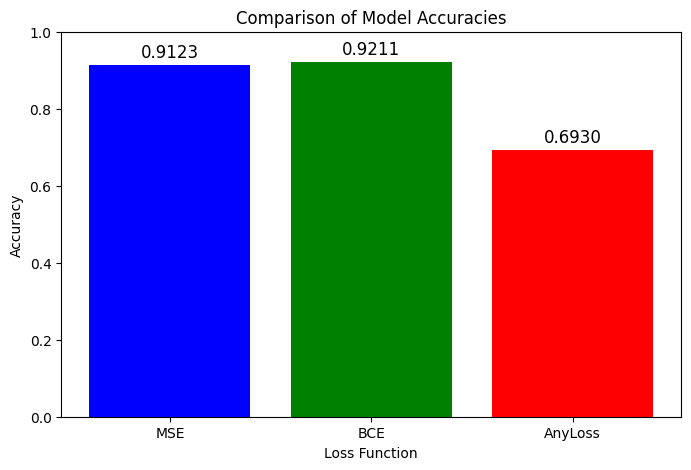

In [7]:
import matplotlib.pyplot as plt
import numpy as np

models = ["MSE", "BCE", "AnyLoss"]

accuracies = [accuracy_mse, accuracy_bce, accuracy]

plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['blue', 'green', 'red'])

plt.xlabel("Loss Function")
plt.ylabel("Accuracy")
plt.title("Comparison of Model Accuracies")
plt.ylim(0, 1)

for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center', fontsize=12)
plt.show()
